# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import jedi
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_profiling
import pygments
import re
import seaborn as sns
from scipy import stats as st
import sklearn
from tqdm import tqdm
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB

Fresh 4.55 %
Milk 6.36 %
Grocery 5.45 %
Frozen 9.77 %
Detergents_Paper 6.82 %
Delicassen 6.14 %
It does not follow the Pareto Principle.


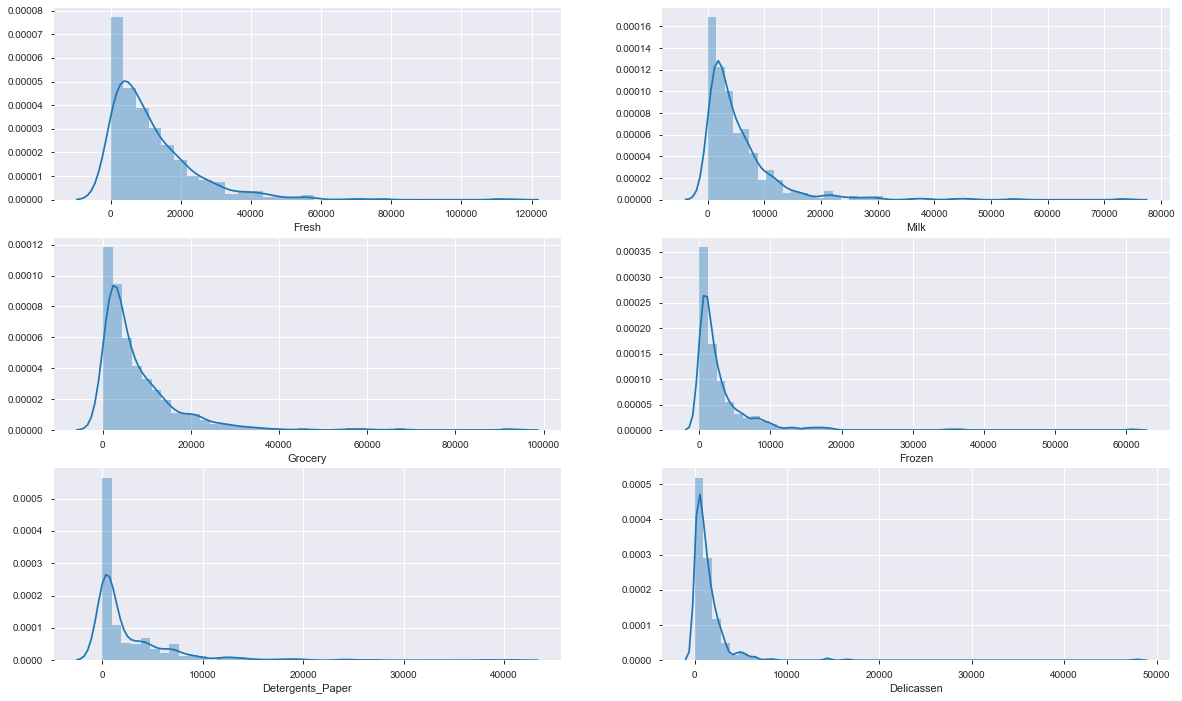

In [44]:
# Your code here:
customers.head()
customers.tail()
customers.info()
round(customers.corr(), 2)
round(customers.describe(), 2)

# checking for percentage of outliers in each column based on IQR <- stole from Mattia.
# quite nifty. With more time I'll think of a more... "pandonic" way of doing it. ^_^
print()
for col in customers.columns[2:]:
    Q1 = customers[col].quantile(0.25)
    Q3 = customers[col].quantile(0.75)
    IQR = Q3 - Q1 
    n_outliers = len([i for i in customers[col] 
                      if (i < Q1 - 1.5 * IQR) | (i > Q3 + 1.5 * IQR)])
    
    print(col, round(n_outliers / len(customers) * 100, 2),"%")

# checking for distribution of columns
fig, ax = plt.subplots(3, 2, figsize = (20, 12))
plt.sca(ax[0, 0])
sns.distplot(customers["Fresh"])
plt.sca(ax[0, 1])
sns.distplot(customers["Milk"])
plt.sca(ax[1, 0])
sns.distplot(customers["Grocery"])
plt.sca(ax[1, 1])
sns.distplot(customers["Frozen"])
plt.sca(ax[2, 0])
sns.distplot(customers["Detergents_Paper"])
plt.sca(ax[2, 1])
sns.distplot(customers["Delicassen"])

# Checking for Pareto Principle
pareto = customers.drop(columns = ["Channel", "Region"]).sum(axis = 1).sort_values(ascending = False)
result = pareto[: int(len(customers) * 0.2)].sum() / pareto.sum()
print("Pareto Principle Verified.") if result >= 0.8 else print("It does not follow the Pareto Principle.") 

In [4]:
# Your observations here
"""
What does each column mean?
    According to the link provided, each column from Fresh to Delicassen is the annual 
    spending on that category (fresh products, milk products, groceries, frozen products, 
    detergents and paper products, and delicatessens), while Channel is if the customer was
    Horeca (Hotel/Restaurant/Cafés) or Retail, and Region is if the customer was located in
    Lisbon, Porto, or somewhere else (other).

Any categorical data to convert?
    There's no categorical data (all columns are int64).
    
Any missing data to remove?
    No.
    
Column collinearity - any high correlations?
    Depending on how one defines high-correlation:
        Grocery <-> Detergents_Paper (above .90)
        Milk <-> Grocery (above .70)
        Milk <-> Detergents_Paper (above .60)
        Grocery & Detergents_Paper <-> Channel (above .60)

Descriptive statistics - any outliers to remove?
    Yes. 
    Fresh 4.55 %
    Milk 6.36 %
    Grocery 5.45 %
    Frozen 9.77 %
    Detergents_Paper 6.82 %
    Delicassen 6.14 %
    
Column-wise data distribution - is the distribution skewed?
    Yes. They're all right skeewd.


It does not follow the Pareto Principle.
"""

"\nWhat does each column mean?\n    According to the link provided, each column from Fresh to Delicassen is the annual \n    spending on that category (fresh products, milk products, groceries, frozen products, \n    detergents and paper products, and delicatessens), while Channel is if the customer was\n    Horeca (Hotel/Restaurant/Cafés) or Retail, and Region is if the customer was located in\n    Lisbon, Porto, or somewhere else (other).\n\nAny categorical data to convert?\n    There's no categorical data (all columns are int64).\n    \nAny missing data to remove?\n    No.\n    \nColumn collinearity - any high correlations?\n    Depending on how one defines high-correlation:\n        Grocery <-> Detergents_Paper (above .90)\n        Milk <-> Grocery (above .70)\n        Milk <-> Detergents_Paper (above .60)\n        Grocery & Detergents_Paper <-> Channel (above .60)\n\nDescriptive statistics - any outliers to remove?\n    Yes. \n    Fresh 4.55 %\n    Milk 6.36 %\n    Grocery 5.45 %\

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [67]:
# Your code here
customers[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].nunique()

Fresh               433
Milk                421
Grocery             430
Frozen              426
Detergents_Paper    417
Delicassen          403
dtype: int64

In [ ]:
# Your comment here
"""
This is interesting; I know that some ML algorithms deal with NaN values (maybe all do..?), so
cleaning the NaN's might not be necessary, but I'm unsure. The same can be said for outliers.

There are a lot of Non-unique values, which, if I'm not mistaken, can be a problem for certain
ML algorithms(?)

Colinearity can also be dealt with in the assigment of variables. 

As such, maybe the data would not need to be cleaned further at this point, as we could adjust as
as we go? 
"""

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [71]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler()

# I was thinking that Channel and Region needed not to be scaled due to their nature, but the
# very first example in the documentation it's scalling Bool values..? So they should be 
# scalled as well?
customers_scale = scaler.fit_transform(customers)

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [78]:
# Your code here:
from sklearn.cluster import KMeans

# should I be passing a number of clusters where? If so, how would I know how many?
kmeans = KMeans(random_state = 42).fit(customers_scale)

# assigning labels of clusters to column
customers["Labels"] = kmeans.labels_ 

# checking
kmeans.labels_ 
kmeans.cluster_centers_
customers.head()
customers["Labels"].unique()

array([2, 0, 6, 5, 1, 7, 3, 4])

Count the values in `labels`.

In [79]:
# Your code here:
customers["Labels"].value_counts()

0    176
2     98
4     87
6     39
5     32
1      5
7      2
3      1
Name: Labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [84]:
# Your code here
from sklearn.cluster import DBSCAN

# Init and fitting the model
clustering = DBSCAN(eps = 0.5).fit(customers_scale)

# assigning the labels_ into the DF col Labels_DBSCAN
customers["Labels_DBSCAN"] = clustering.labels_

# checking
clustering.labels_
clustering
customers.head()
customers["Labels_DBSCAN"].unique()

array([-1,  1,  0,  3,  2,  4,  5,  6,  7])

Count the values in `labels_DBSCAN`.

In [85]:
# Your code here
customers["Labels_DBSCAN"].value_counts()

-1    255
 1    130
 5     22
 4      7
 6      6
 2      5
 7      5
 3      5
 0      5
Name: Labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

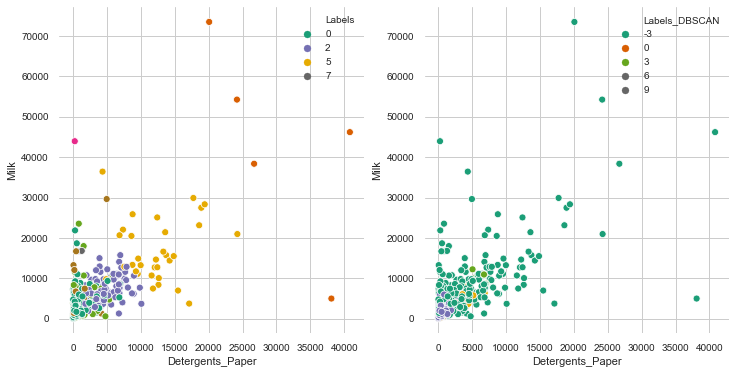

In [92]:
# Your code here:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

plt.sca(ax[0])
sns.scatterplot(x = "Detergents_Paper", y = "Milk", hue = "Labels", data = customers, 
                palette = "Dark2")

plt.sca(ax[1])
sns.scatterplot(x = "Detergents_Paper", y = "Milk", hue = "Labels_DBSCAN", data = customers,
                palette = "Dark2")

# I'm confused; the number of labels do not correspond to the dots (look at the first one, w/
# 4 labels, but the red dots — for instance — are not descriminated in the labels?)

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

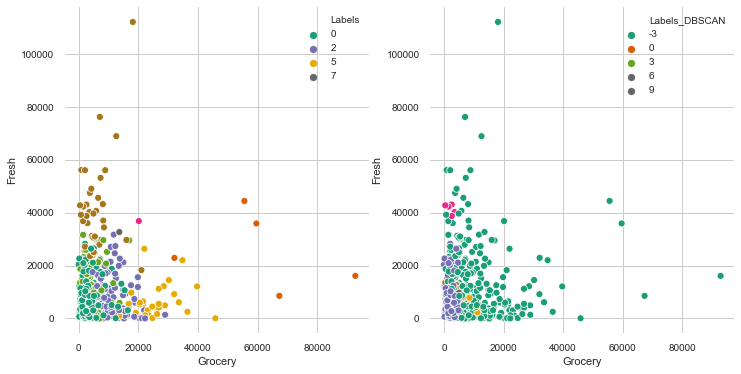

In [93]:
# Your code here:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

plt.sca(ax[0])

sns.scatterplot(x = "Grocery", y = "Fresh", hue = "Labels", data = customers, 
                palette = "Dark2")

plt.sca(ax[1])
sns.scatterplot(x = "Grocery", y = "Fresh", hue = "Labels_DBSCAN", data = customers,
                palette = "Dark2")

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

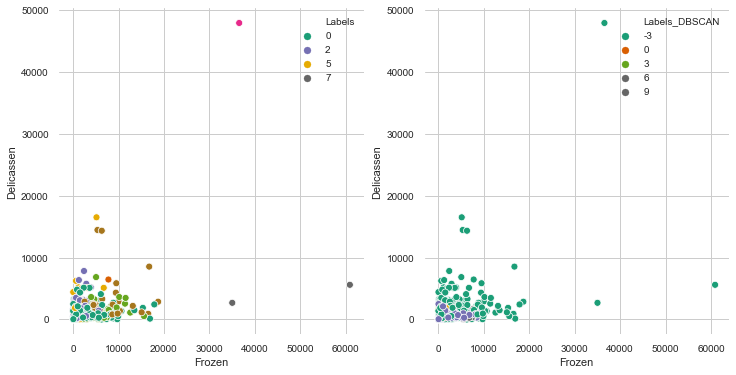

In [94]:
# Your code here:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

plt.sca(ax[0])
sns.scatterplot(x = "Frozen", y = "Delicassen", hue = "Labels", data = customers,
                palette = "Dark2")

plt.sca(ax[1])
sns.scatterplot(x = "Frozen", y = "Delicassen", hue = "Labels_DBSCAN", data = customers,
                palette="Dark2")

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [97]:
# Your code here:
round(customers.drop("Labels_DBSCAN", axis = 1).groupby(by = "Labels").mean(), 2)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels,,,,,,,,
0,1.00,3.00,8926.84,2940.68,3419.88,2687.67,773.28,1002.56
1,2.00,2.80,25603.00,43460.60,61472.20,2636.00,29974.20,2708.80
2,2.00,2.78,8269.97,7533.82,11740.94,1331.82,4847.29,1476.65
3,1.00,3.00,36847.00,43950.00,20170.00,36534.00,239.00,47943.00
4,1.06,1.32,10590.05,3182.54,4112.39,3233.48,862.02,1096.28
5,2.00,2.28,5985.44,16817.62,25628.66,1840.00,12321.75,2455.09
6,1.05,2.79,40430.51,5084.92,5767.64,6726.08,922.59,2719.15
7,1.00,2.50,22015.50,9937.00,7844.00,47939.00,671.50,4153.50


In [98]:
round(customers.drop("Labels", axis = 1).groupby(by = "Labels_DBSCAN").mean(), 2)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels_DBSCAN,,,,,,,,
-1,1.49,2.45,13729.56,8359.89,11484.36,3795.00,4356.80,2080.47
0,2.00,3.00,11401.00,3536.20,6729.00,720.20,3561.00,258.20
1,1.00,3.00,9128.82,1862.44,2423.53,2131.43,496.58,741.95
2,1.00,3.00,41446.60,1421.20,2167.60,1276.40,416.20,784.80
3,2.00,3.00,2357.20,10224.80,11862.80,609.60,5780.00,572.80
4,2.00,3.00,3068.14,6095.86,10355.00,994.00,4675.57,1826.43
5,1.00,1.00,9837.86,1751.86,2161.68,1513.18,333.95,669.05
6,1.00,1.00,6823.00,1943.00,2372.67,6780.33,386.50,613.67
7,1.00,2.00,7494.60,1537.60,3383.00,2575.40,227.40,941.00


Which algorithm appears to perform better?

In [ ]:
# Your observations here
"""
I do not understand, so I don't know. By eye they seem both pretty terrible, but I don't
know.
"""

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here